# NLP - Word Embeddings and Dimensionality Reduction in Natural Language Processing with the ArXiv dataset

MW Maddock

2023-12-04


## 1. Introduction

- **Transformers & Word Embeddings**

The Transformer model, introduced by [Vaswani et al.](https://arxiv.org/abs/1706.03762) in 2017, marked an important moment in NLP. Unlike traditional sequential models, Transformers leverage self-attention mechanisms to capture global dependencies and contextual information in parallel. This architectural leap not only led to remarkable improvements in various NLP tasks but also introduced a novel way of creating word embeddings.

In the context of Transformers, word embeddings are not static representations but dynamic, contextualized vectors that capture the meaning of a word based on its surrounding context in a sentence. Models like BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer) have demonstrated unparalleled prowess in learning nuanced language representations.

- **The Challenge of Dimensionality**

While word embeddings provide rich representations of language, they often come with high dimensionality. The curse of dimensionality can lead to computational inefficiencies, increased memory requirements, and challenges in visualizing or interpreting the learned representations. This is where dimensionality reduction techniques step in.

- **Dimensionality Reduction Techniques**

Dimensionality reduction aims to capture the essential features of high-dimensional data while discarding redundant or less informative ones. In the context of word embeddings, techniques like Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and Uniform Manifold Approximation and Projection (UMAP) become invaluable. Through these methods, we can visualize and analyze the structure of word embeddings in a lower-dimensional space, making them more manageable and interpretable.

## 2. What is in this Notebook

In this notebook, we will walk through the implementation of word embeddings using popular libraries such as `spaCy` and `sentence-transformers`. We'll then address the challenge of dimensionality by applying dimensionality reduction techniques and visualizing the results. Through this you'll gain a deeper understanding of how these concepts work in the context of NLP.


## 3. Load the Dataset

### 3.1 About the Arxiv dataset

For nearly 30 years, ArXiv has served the public and research communities by providing open access to scholarly articles, from the vast branches of physics to the many subdisciplines of computer science to everything in between, including math, statistics, electrical engineering, quantitative biology, and economics. This rich corpus of information offers significant, but sometimes overwhelming depth.

The data can be found [here](https://www.kaggle.com/datasets/Cornell-University/arxiv)

Below we load the dataset into a pandas dataframe for analysis and visualization.

In [1]:
!!pip install -U sentence-transformers
!pip install umap-learn

In [2]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import umap
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import  json

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
! ls -la

total 56
drwxr-xr-x 2 root root  4096 Dec  8 11:09 .
drwxr-xr-x 6 root root  4096 Dec  8 11:09 ..
---------- 1 root root 47509 Dec  8 11:11 __notebook__.ipynb


In [4]:
cols = ['id', 'title', 'abstract', 'categories']
data = []
file_name = '/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json'

with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['id'], doc['title'], doc['abstract'], doc['categories']]
        data.append(lst)

df = pd.DataFrame(data=data, columns=cols).sample(n=10_000, random_state=68)

df.head()

,id,title,abstract,categories
2228870,hep-th/0405087,Torsion cycles as non-local magnetic sources i...,Non-orientable spaces can appear to carry ne...,hep-th
665221,1510.01264,Gama and beta approximations via general order...,"In this paper, we introduce the concepts of ...",math.GM
461519,1309.4511,Robust Heterogeneous Network to Support Multit...,"Due to emerging technology, efficient multit...",cs.NI
1382518,2011.09770,Freecyto: Quantized Flow Cytometry Analysis fo...,Flow cytometry (FCM) is an analytic techniqu...,q-bio.QM stat.AP
1089268,1902.08184,Stability conditions in families,We develop a theory of Bridgeland stability ...,math.AG


In [5]:
df.shape

(10000, 4)

## 3. Covert Abstract into Vector Representation

### 3.1 Brief introduction to NLP

For a more detailed intorduction to

#### 3.1.1 Definition

Natural Language Processing (NLP) is a field of artificial intelligence that focuses on the interaction between computers and humans through natural language. NLP enables computers to understand, interpret, and generate human language in a way that is both valuable and meaningful. Applications of NLP include language translation, sentiment analysis, chatbots, and text summarization, among others.

#### 3.1.1 Bag of words

Natural language consists of sentences/documents with a **variable length** sequences of text, but the problem is machine learning algorithms require **fixed length** vectors of numbers.

The **simplest** approach to overcome this is by using a **bag-of-words**, which simply **counts how many times each word appears** in a document. It's called a **bag** because the **order of the words is ignored** - we only care about whether a word appeared or not.

<center>
<img src='https://i.postimg.cc/pLvhy7zs/basicbow.png' width=600>
</center>
<br>

The linguistic reasoning behind this approach is that **similar documents share similar vocabularies**. For example, football articles will often use words like *score*, *pass*, *team* whereas weather reports will use a completely different set of words like *rain*, *sun*, *umbrella*.

We might want to **remove stop words** (common words that have little meaning like *the*, *of*, *how*) to make it easier to identify similar documents as these will be in pretty much all documents.

#### 3.1.2 Word Embeddings

Using bag of words it is possible to **vectorize documents**, another common approach is known as TF-IDF. While these approaches work well for simple NLP tasks like classification, they have the drawback that they don't capture any relationships between words.

However it is possible to **vectorize individual words** via **static embeddings** in order to **capture word meaning** or **contextual embeddings** where the embedding can change depending on the context.

The simplest way to vectorize a set of words, is to use **one-hot encoding**. This maps each word into a vector with length equal to the size of the vocabulary. The vector is completely filled with 0's except for a single entry, which has a 1 correspoding to the index of the word in the vocabulary.

<br>
<center>
<img src="https://i.postimg.cc/65VjcWzg/onehot.png" width=600>
</center>
<br>

This is a pretty **terrible way** to vectorize words, not only because it is very **memory inefficient** but also because there is no relationship between words. In particular, if the voculary contains 10,000 words, then each vector has length equal to 10,000. Furthermore, any two distinct vectors will always have a **dot product equal to 0**, corresponding to no similarity.

<br>

A better way then would be to represent words as **shorter and denser vectors** that capture some meaning between words. And this is what an embedding aims to do.

An **embedding** is simply a **representation of an object** (e.g. a word, movie, graph, etc) as a **vector of real numbers**. It *embeds* an object into a **high-dimensional vector space**.

<br>
<center>
<img src="https://i.postimg.cc/9FZq6z7X/unitcube.png" width=300>
</center>
<br>

For example, let's say you have a collection of videos games. We can represent each game by measuring a number of its **attributes** like `[<fantasy>,<strategy>,<multiplayer>,<action>,<adventure>]`. So a game like 'Minecraft' could be represented by `[0.1,0.6,0.4,0.5,0.9]` (although the numbers don't have to be between 0 and 1) and if we wanted to find similar game, we could return the game with the **highest similar score**.

Notice how there are many **different ways to embed the same object**. Moreover, the features we hand-selected may not be the best ones to represent these objects. But the main idea is to find a representation where **similar objects** (i.e. are semantically similar) are **close together**. We can do this with words too, but how do we find their best representations?

<br>
<center>
<img src="https://i.postimg.cc/zv5V5FWJ/embed.webp" width=700>
</center>
<br>

To train a word embedding, we first need to ask ourselves what makes two words **semantically similar**? One popular answer to this is the **distributional hypothesis**, which says that "words which appear in **similar contexts** (i.e. share similar surrounding words) have **similar meanings**".

For example, consider the sentence "My family enjoys eating bacalhau at Christmas". You probably have no idea what 'bacalhau' is but just from the **context** we can **infer** that it is some kind of food. (In fact, the word refers to Portuguese salted cod.)

That are many algorithms that use this idea to **train word embeddings**. We are going to focus on the main one, namely **Word2vec**, which was developed in 2013 at Google and was a breakthrough in NLP at the time. ([link to paper](https://arxiv.org/abs/1301.3781))

In this notebook we will be using **pre-trained transformers** to embed research papers from the ArXiv dataset and apply dimensionality reduction inorder to visualize the papers in a lower dimensional vector space. Transformers are the current **state-of-the-art transformer model**.

This model originates from the 2017 [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper and still **dominates** the field of NLP today. For example, you've probably heard of the **conversational AI ChatGPT** by OpenAI - well this is based on the transformer model (GPT = Generative Pre-trained *Transformer*)!


### 3.2 The Implementation

The code below performs semantic embedding of textual abstracts using the Sentence Transformers library, focusing on the pre-trained model named `allenai-specter`. To read more about the `allenai-specter` model [here](https://huggingface.co/sentence-transformers/allenai-specter)


- **Device Configuration:** The code begins by determining the computing device to be used. It checks whether a GPU (cuda) is available, and if so, it assigns the device as `cuda:0`; otherwise, it defaults to the CPU. This is a crucial step for optimizing the computational efficiency of the subsequent operations.

- **Abstract Retrieval:** The abstracts from a DataFrame (`df`) are extracted and converted into a list named `abstracts`. These abstracts contain textual information, such as research summaries or document content.

- **Loading Sentence Transformer Model:** The code then initializes a Sentence Transformer model using `allenai-specter`. Sentence Transformers are designed to generate meaningful embeddings for sentences or text passages, capturing semantic relationships and contextual information.

- **Device Assignment:** The model is moved to the specified device (either GPU or CPU) using the `to(device)` method. This ensures that the model's computations are performed on the chosen hardware for optimal performance.

- **Embedding Generation:** The `encode` method of the model is then applied to the list of abstracts (`abstracts`). This step involves transforming the textual content into dense vector representations, or embeddings, that encapsulate semantic information. These embeddings aim to preserve the contextual meaning of the abstracts and can be used for various downstream tasks such as clustering, classification, or similarity analysis.

- **Result Display:** The resulting embeddings are stored in the variable `embeddings`. This variable will be further utilized as an input to a dimensionality reduction algorithm known as `UMAP` which will allow for the dataset to be visualised.

**Note:** CUDA is a parallel computing platform and application programming interface model developed by NVIDIA. CUDA is used to accelerate the training process by offloading computations to the parallel processing capabilities of NVIDIA GPUs, significantly speeding up both the training and inference of deep learning models (Transformers in the case).

**How to use GPU with Colab?**

- Click on "Runtime" in the top menu.
- Select "Change runtime type."
- Choose "T4 GPU" as the hardware accelerator.
- Click "Save."

The code below will take several hours to run if a GPU is not enabled

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Should say cuda:0
device

'cuda:0'

Extract abstracts from dataset

In [7]:
abstracts = df.abstract.tolist()

Load the transformer model

In [8]:
model = SentenceTransformer('sentence-transformers/allenai-specter')
model = model.to(device)

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Compute the embeddings for each abstract

In [9]:
embeddings = model.encode(abstracts)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [10]:
embeddings

array([[ 0.00520426,  0.48020458,  0.79931986, ...,  0.49462062,
         0.0653358 , -0.03888965],
       [-0.540247  , -0.11507387, -0.8305519 , ...,  0.0980404 ,
         0.13460672, -0.05909311],
       [-0.46851358,  0.16730599,  0.45477343, ...,  0.74027306,
        -0.6819455 ,  0.8055632 ],
       ...,
       [ 0.04853689,  0.49820092,  0.5499362 , ...,  0.20928827,
         0.52535003, -0.2005255 ],
       [-1.3221459 , -0.9137772 ,  0.56937957, ..., -0.40728855,
         0.85394335, -0.09585036],
       [-0.4267122 ,  0.4538063 , -0.2680957 , ..., -0.01355467,
         0.9873081 ,  0.4680331 ]], dtype=float32)

Here we can see that there are $10 000$ abstracts and each abstract is represented as a vector; $v \in \mathbb{R}^{768}$. Amazing right?

In [11]:
embeddings.shape

(10000, 768)

### 3.3 Preprocessing and ArXiv Taxonomy - Not Compulsary

Here we need to do some processing to ensure that the data can be visualized effectively. Each paper belongs to a category labelled by a `category_id` however ther are $2266$ unique values so it isnot possible to effectively visualize the embeddings. There for in the section we use the [ArXiv Taxonomy](https://arxiv.org/category_taxonomy) to classify these paper into 8 broader fields, namely CS, Economics, Engineering, Physics, Mathematics, Biology, Finance & Statistics


In [12]:
df.head()

,id,title,abstract,categories
2228870,hep-th/0405087,Torsion cycles as non-local magnetic sources i...,Non-orientable spaces can appear to carry ne...,hep-th
665221,1510.01264,Gama and beta approximations via general order...,"In this paper, we introduce the concepts of ...",math.GM
461519,1309.4511,Robust Heterogeneous Network to Support Multit...,"Due to emerging technology, efficient multit...",cs.NI
1382518,2011.09770,Freecyto: Quantized Flow Cytometry Analysis fo...,Flow cytometry (FCM) is an analytic techniqu...,q-bio.QM stat.AP
1089268,1902.08184,Stability conditions in families,We develop a theory of Bridgeland stability ...,math.AG


In [13]:
df.categories.nunique()

2266

In [14]:
## load taxonomy from https://arxiv.org/category_taxonomy
website_url = requests.get('https://arxiv.org/category_taxonomy').text
soup = BeautifulSoup(website_url,'lxml')

root = soup.find('div',{'id':'category_taxonomy_list'})

tags = root.find_all(["h2","h3","h4","p"], recursive=True)

level_1_name = ""
level_2_code = ""
level_2_name = ""

level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

for t in tags:
    if t.name == "h2":
        level_1_name = t.text
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw)
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'category_id' : level_3_codes,
    'category_description': level_3_notes

})
df_taxonomy.to_csv("arxiv-metadata-ext-taxonomy.csv", index=False)
df_taxonomy.groupby(["group_name","archive_name"]).head(3)

/opt/conda/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


,group_name,archive_name,archive_id,category_name,category_id,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
40,Economics,Economics,Economics,Econometrics,econ.EM,"Econometric Theory, Micro-Econometrics, Macro-..."
41,Economics,Economics,Economics,General Economics,econ.GN,"General methodological, applied, and empirical..."
42,Economics,Economics,Economics,Theoretical Economics,econ.TH,Includes theoretical contributions to Contract...
43,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Audio and Speech Processing,eess.AS,Theory and methods for processing signals repr...
44,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Image and Video Processing,eess.IV,"Theory, algorithms, and architectures for the ..."
45,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Signal Processing,eess.SP,"Theory, algorithms, performance analysis and a..."
47,Mathematics,Mathematics,Mathematics,Commutative Algebra,math.AC,"Commutative rings, modules, ideals, homologica..."


In [15]:
groups = df_taxonomy.group_name.tolist()
categories = df_taxonomy.category_id.tolist()

replacements = { c : g for c, g in zip(categories, groups)}

replacements = {"astro-ph" : "Physics",
                "q-alg" : "Physics",
                "cond-mat" : "Physics",
                "chao-dyn" : "Mathematics",
                "chem-ph" : "Physics",
                "plasm-ph" : "Physics",
                "alg-geom" : "Mathematics",
                "cmp-lg" : "Computer Science",
                "patt-sol" : "Physics",
                "dg-ga" : "Mathematics",
                "funct-an" : "Mathematics",
                "mtrl-th" : "Physics",
                **replacements}

replacements

{'astro-ph': 'Physics',
 'q-alg': 'Physics',
 'cond-mat': 'Physics',
 'chao-dyn': 'Mathematics',
 'chem-ph': 'Physics',
 'plasm-ph': 'Physics',
 'alg-geom': 'Mathematics',
 'cmp-lg': 'Computer Science',
 'patt-sol': 'Physics',
 'dg-ga': 'Mathematics',
 'funct-an': 'Mathematics',
 'mtrl-th': 'Physics',
 'cs.AI': 'Computer Science',
 'cs.AR': 'Computer Science',
 'cs.CC': 'Computer Science',
 'cs.CE': 'Computer Science',
 'cs.CG': 'Computer Science',
 'cs.CL': 'Computer Science',
 'cs.CR': 'Computer Science',
 'cs.CV': 'Computer Science',
 'cs.CY': 'Computer Science',
 'cs.DB': 'Computer Science',
 'cs.DC': 'Computer Science',
 'cs.DL': 'Computer Science',
 'cs.DM': 'Computer Science',
 'cs.DS': 'Computer Science',
 'cs.ET': 'Computer Science',
 'cs.FL': 'Computer Science',
 'cs.GL': 'Computer Science',
 'cs.GR': 'Computer Science',
 'cs.GT': 'Computer Science',
 'cs.HC': 'Computer Science',
 'cs.IR': 'Computer Science',
 'cs.IT': 'Computer Science',
 'cs.LG': 'Computer Science',
 'cs.LO

In [16]:
category_df = pd.DataFrame(df.categories.str.split(" ").to_list())

df["group_name"] = category_df.replace(replacements).iloc[:, 0].to_list()

df.head()

,id,title,abstract,categories,group_name
2228870,hep-th/0405087,Torsion cycles as non-local magnetic sources i...,Non-orientable spaces can appear to carry ne...,hep-th,Physics
665221,1510.01264,Gama and beta approximations via general order...,"In this paper, we introduce the concepts of ...",math.GM,Mathematics
461519,1309.4511,Robust Heterogeneous Network to Support Multit...,"Due to emerging technology, efficient multit...",cs.NI,Computer Science
1382518,2011.09770,Freecyto: Quantized Flow Cytometry Analysis fo...,Flow cytometry (FCM) is an analytic techniqu...,q-bio.QM stat.AP,Quantitative Biology
1089268,1902.08184,Stability conditions in families,We develop a theory of Bridgeland stability ...,math.AG,Mathematics


In [17]:
df["group_name"].unique()

array(['Physics', 'Mathematics', 'Computer Science',
       'Quantitative Biology', 'Quantitative Finance',
       'Electrical Engineering and Systems Science', 'Statistics',
       'Economics'], dtype=object)

## 4. Dimensionailty Reduction - UMAP

Uniform Manifold Approximation and Projection (UMAP), is a dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in a lower-dimensional space. It aims to preserve the local structure and relationships within the data while reducing dimensionality, making it well-suited for applications like visualizing word embeddings. UMAP constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible. While the mathematics UMAP uses to construct the high-dimensional graph is advanced, the intuition behind them is remarkably simple.

In order to construct the initial high-dimensional graph, UMAP builds something called a "fuzzy simplicial complex". This is really just a representation of a weighted graph, with edge weights representing the likelihood that two points are connected. To determine connectedness, UMAP extends a radius outwards from each point, connecting points when those radii overlap. Choosing this radius is critical - too small a choice will lead to small, isolated clusters, while too large a choice will connect everything together. UMAP overcomes this challenge by choosing a radius locally, based on the distance to each point's nth nearest neighbor. UMAP then makes the graph "fuzzy" by decreasing the likelihood of connection as the radius grows. Finally, by stipulating that each point must be connected to at least its closest neighbor, UMAP ensures that local structure is preserved in balance with global structure.

Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible. This process is essentially the same as in t-SNE, but using a few clever tricks to speed up the process. Read [here](https://pair-code.github.io/understanding-umap/) for more information on the mathematics behind UMAP.

To implement UMAP with word embeddings for visualization, you can start by representing words as high-dimensional vectors using pre-trained word embeddings, using transformers in this case. These embeddings capture semantic relationships between words based on their context in a given corpus. Once you have these word embeddings, we use UMAP to reduce the dimensionality of the embeddings while preserving the semantic relationships. This lower-dimensional representation can then be visualized in a 2D or 3D space, allowing you to explore and interpret the semantic similarities and relationships between words. Such visualizations are valuable for tasks like exploring word semantics, identifying clusters of related terms, and gaining insights into the underlying structure of the high-dimensional word embedding space.

In [18]:
reducer = umap.UMAP(n_neighbors=5,
                    n_components=2,
                    n_jobs = -1)

embedding_2d = reducer.fit_transform(embeddings)

In [19]:
embedding_2d[:, 0]

array([-1.4722843 ,  0.86164045, -3.2137382 , ...,  2.7169752 ,
        5.012463  ,  4.7648835 ], dtype=float32)

In [20]:
df["abstract_vector_x"] = embedding_2d[:, 0]
df["abstract_vector_y"] = embedding_2d[:, 1]

df.head()

,id,title,abstract,categories,group_name,abstract_vector_x,abstract_vector_y
2228870,hep-th/0405087,Torsion cycles as non-local magnetic sources i...,Non-orientable spaces can appear to carry ne...,hep-th,Physics,-1.472284,7.424874
665221,1510.01264,Gama and beta approximations via general order...,"In this paper, we introduce the concepts of ...",math.GM,Mathematics,0.861640,1.070119
461519,1309.4511,Robust Heterogeneous Network to Support Multit...,"Due to emerging technology, efficient multit...",cs.NI,Computer Science,-3.213738,1.361186
1382518,2011.09770,Freecyto: Quantized Flow Cytometry Analysis fo...,Flow cytometry (FCM) is an analytic techniqu...,q-bio.QM stat.AP,Quantitative Biology,-0.789641,1.673596
1089268,1902.08184,Stability conditions in families,We develop a theory of Bridgeland stability ...,math.AG,Mathematics,-2.450723,7.842294


## 5. Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

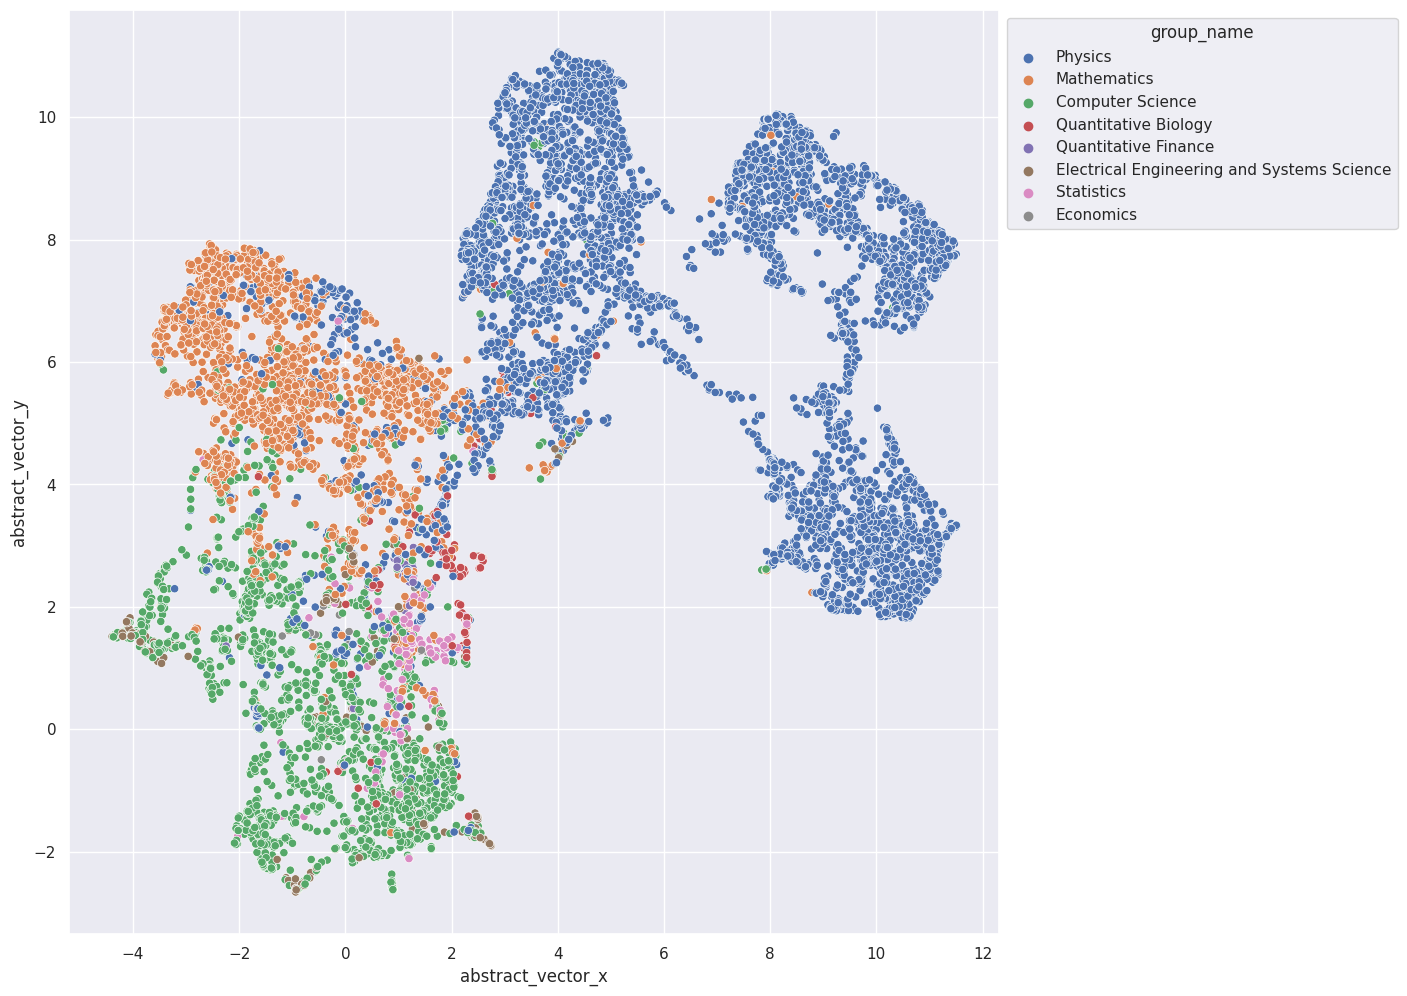

In [21]:
sns.set(context="paper", style="white")
sns.set(rc = {'figure.figsize' : (12, 12)})

ax = sns.scatterplot(data=df,
                x="abstract_vector_x",
                y="abstract_vector_y",
                hue="group_name")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))